# National Survey on Drug Use and Health Analysis
### Data from: 2012 (ICPSR 34933)

The National Survey on Drug Use and Health (NSDUH) is primarily used to measure the prevalence of drug use in the United 
States.
In this exploratory data analysis we will look at the correlation of overall drug abuse patters including:
* Cigarette use transitioning to marijuana use
* Marijuana as a gateway drug
* Prescription painkiller use leading to heroin use
* Beginning age of use as an indicator of later drug use

In the [machine learning](https://www.github.com/msloma144/ICPSR_analyis/machine_learning.ipynb) notebook we look at 
using background information to attempt to predict hard drug use.

The data in this study is mostly self reported, so we need to keep that in mind while performing our evaluation.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# correlation helper
def visualize_data(df, rows=None):
    df_corr = df.corr()
    print(df_corr.head(10))

    data = df_corr.values
    
    if rows is not None:
        data = data[rows].reshape(len(rows), data.shape[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)

    ax.set_xticks(np.arange(data.shape[0]), minor=False)
    ax.set_yticks(np.arange(data.shape[1]), minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

In [3]:
# Load the data
data = pd.read_csv('DS0001/34933-0001-Data.tsv', sep='\t', header=0)
print(data.shape)
print(data.head())
# check for missing values
print(data[np.isinf(data.values).any(axis=1)])
print(data[np.isnan(data.values).any(axis=1)])

(55268, 3120)
   CASEID  QUESTID2  CIGEVER  CIGOFRSM  CIGWILYR  CIGTRY  CIGYFU  CIGMFU  \
0       1  50886467        2         4         4     991    9991      91   
1       2  13766883        2        99        99     991    9991      91   
2       3  17772877        2        99        99     991    9991      91   
3       4  45622817        1        99        99      13    9999      99   
4       5  17239390        1        99        99      11    9999      99   

   CIGREC  CIG30USE  ...  IIEMPSTY  II2EMSTY  EMPSTAT4  IIEMPST4  II2EMST4  \
0      91        91  ...         1         1        99         9         9   
1      91        91  ...         1         1         1         1         1   
2      91        91  ...         1         1         1         1         1   
3       2        93  ...         1         1         2         1         1   
4       4        93  ...         1         1         1         1         1   

   PDEN00  COUTYP2      ANALWT_C  VESTR  VEREP  
0       2  

## Cigarette Use Transitioning To Marijuana Use
In this analysis, we explore the relationship of marijuana and cigarette. We use four variables from the study; if 
cigarettes have _ever_  been used, if marijuana has _ever_ been used, if cigarettes were used in the past 30 days, and
if marijuana was used in the past 30 days. The "past 30 days" metric shows that they likely did not just try it once,
but are likely a chronic user of the drug. We change each of these to binary values (0 for having never done the drug 
or 1 for having done it).

Variables from the NSDUH study:
* CIGEVER: EVER USED CIGERTES

    1 = yes
    
    0 = no
    
* CIGREC: TIME SINCE LAST SMOKED CIGARETTES

    1 = Within the past 30 days
    
    0 = Other *
    
* MJEVER: EVER USED MARIJUANA/HASHISH

    1 = yes
    
    0 = no
    
* MJREC: TIME SINCE LAST USED MARIJUANA/HASHISH

    1 = Within the past 30 days
    
    0 = Other *
    
\* All other time amounts are considers as not a chronic user.

In [39]:
data_selection = data[["CIGEVER", "CIGREC", "MJEVER", "MJREC"]]

data_selection.loc[data_selection['CIGREC'] != 1, 'CIGREC'] = 0
data_selection.loc[data_selection['MJREC'] != 1, 'MJREC'] = 0

data_selection.loc[data_selection['CIGEVER'] != 1, 'CIGEVER'] = 0
data_selection.loc[data_selection['MJEVER'] != 1, 'MJEVER'] = 0

print(data_selection.head())

   CIGEVER  CIGREC  MJEVER  MJREC
0        0       0       0      0
1        0       0       0      0
2        0       0       0      0
3        1       0       1      1
4        1       0       0      0


We then analyze the correlation coefficients between these four variables.

          CIGEVER    CIGREC    MJEVER     MJREC
CIGEVER  1.000000  0.536949  0.557197  0.253175
CIGREC   0.536949  1.000000  0.399840  0.309268
MJEVER   0.557197  0.399840  1.000000  0.422643
MJREC    0.253175  0.309268  0.422643  1.000000


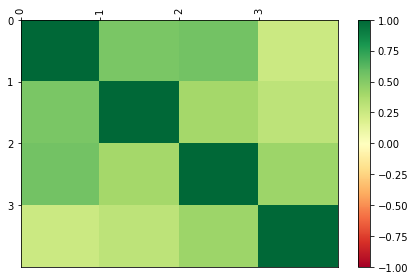

In [40]:
visualize_data(data_selection)

We can see that there is a decent correlation (0.54) between trying cigarettes and using cigarettes in the past 30 days,
and also that there is also a decent correlation (0.56) between trying cigarettes and trying marijuana. The relationship 
between chronic cigarette users and chronic marijuana seems to be much lower, with a correlation coefficient of only 0.31. 
Finally, it can be seen that the correlation of trying marijuana and using marijuana regularly is not near as high as 
the correlation between the indicators for cigarettes (0.42 v 0.54). Based on this analysis, it seems unlikely that 
there is major overlap between cigarette users and marijuana users however, there is an indication that trying cigarettes 
will lead to trying marijuana.  There is also evidence of the addictive factor of cigarettes, as the correlation
coefficient between just trying cigarettes and being a chronic user is moderately high, especially compared to marijuana. 

## Marijuana as a Gateway Drug
One common argument against recreational marijuana laws is that it will be a gateway drug to harder drugs in the future;
This analysis delves into this idea as we explore the relationship between marijuana use and harder drug use. 
We pick seven variables, if marijuana has ever been used, if it was used in the past 30 days, if cocaine has ever been used,
if heroin has ever been used, if hallucinogens have ever been used, if inhalants have ever been used, and finally if non-prescribed 
prescription painkillers have ever been used. For the hallucinogens, inhalants and painkillers, we need to extract the amount who
have never used the drug, which is show for each type of drug class, and is then broken down into more granular drugs.
Since we are only looking at the overall classes, we can just take that number from the first drug type of each class (refer
to the data for more information).

Variables from the NSDUH study:
* MJEVER: EVER USED MARIJUANA/HASHISH

    1 = yes
    
    0 = no
    
* MJREC: TIME SINCE LAST USED MARIJUANA/HASHISH

    1 = Within the past 30 days
    
    0 = Other *
    
* COCEVER: EVER USED COCAINE

    1 = yes
    
    0 = no
    
* HEREVER: EVER USED HEROIN

    1 = yes
    
    0 = no

* --HALLUCINOGENS
* LSD: EVER USED LSD ("ACID")

    1 = yes
    
    0 = no

* --INHALANTS
* AMYLNIT: EVER INHALED AMYL NITRITE, 'POPPERS,' RUSH, ETC. Freq Pct

    1 = yes
    
    0 = no

* --PAIN RELIEVERS
* DARVTYLC: EVER USED DARVOCET, DARVON, OR TYLENOL W/ CODEINE

    1 = yes
    
    0 = no
    

In [42]:
data_selection = data[["MJEVER", "MJREC", "COCEVER", "HEREVER", "LSD", "AMYLNIT", "DARVTYLC"]]

# MARIJUANA
data_selection.loc[data_selection['MJEVER'] != 1, 'MJEVER'] = 0
data_selection.loc[data_selection['MJREC'] != 1, 'MJREC'] = 0

# COCAINE
data_selection.loc[data_selection['COCEVER'] != 1, 'COCEVER'] = 0

# HEROIN
data_selection.loc[data_selection['HEREVER'] != 1, 'HEREVER'] = 0

# HALLUCINOGENS
data_selection.loc[data_selection['LSD'] != 91, 'LSD'] = 1
data_selection.loc[data_selection['LSD'] == 91, 'LSD'] = 0

# INHALANTS
data_selection.loc[data_selection['AMYLNIT'] != 91, 'AMYLNIT'] = 1
data_selection.loc[data_selection['AMYLNIT'] == 91, 'AMYLNIT'] = 0

# PAIN RELIEVERS
data_selection.loc[(data_selection["DARVTYLC"] == 91) | (data_selection["DARVTYLC"] == 81), 'DARVTYLC'] = 0
data_selection.loc[(data_selection["DARVTYLC"] != 0), 'DARVTYLC'] = 1

print(data_selection.head())

   MJEVER  MJREC  COCEVER  HEREVER  LSD  AMYLNIT  DARVTYLC
0       0      0        0        0    0        0         0
1       0      0        0        0    0        0         0
2       0      0        0        0    0        0         0
3       1      1        1        0    1        0         0
4       0      0        0        0    0        0         0


            MJEVER     MJREC   COCEVER   HEREVER       LSD   AMYLNIT  DARVTYLC
MJEVER    1.000000  0.422643  0.411049  0.144564  0.438396  0.231772  0.330673
MJREC     0.422643  1.000000  0.281007  0.129407  0.368165  0.187803  0.285053
COCEVER   0.411049  0.281007  1.000000  0.318479  0.574959  0.322684  0.369791
HEREVER   0.144564  0.129407  0.318479  1.000000  0.255902  0.195508  0.213250
LSD       0.438396  0.368165  0.574959  0.255902  1.000000  0.351173  0.397328
AMYLNIT   0.231772  0.187803  0.322684  0.195508  0.351173  1.000000  0.290249
DARVTYLC  0.330673  0.285053  0.369791  0.213250  0.397328  0.290249  1.000000


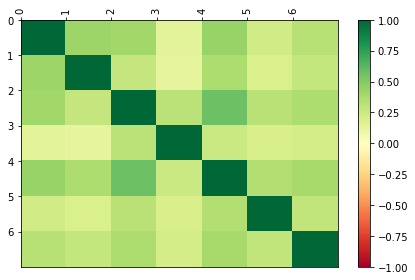

In [43]:
visualize_data(data_selection)

There are a couple intresting correlations we can look into. The National Institute on Drug Abuse (NIDA) has performed several
[studies](https://www.drugabuse.gov/publications/research-reports/marijuana/marijuana-gateway-drug) 
on if marijuana will lead to harder drug abuse. They go on to state that "...the majority of people who use marijuana 
do not go on to use other, "harder" substances." We can see an argument for both sides in our data. While the correlation
coefficients on trying marijuana and trying heroin, inhalants or prescription pain killers are low 
(0.14, 0.23, 0.33 respectively), the correlation coefficients on cocaine and LSD are moderate at .41 and .43 respectively.
The story stays pretty similar if we look at chronic marijuana users, with the coefficients reduced, but not substantially.

This shows that while on the whole, our data would agree with the NIDA's findings that the majority of chronic marijuana
users do not go on to use harder drugs. The exceptions seem to be with LSD and cocaine. This could be due marijuana having
similar but milder effects than LSD, resulting in users wanting more a "psychedelic" experience. Cocaine could be used
to counteract the effects of the marijuana, or vice vera to keep a balance of the feelings, potentially explaining the
higher correlation.

## Prescription Painkiller Use Leading to Heroin Use
With the opioid crisis afoot, it is interesting to look at the relationship between non-prescribed prescription painkillers
and heroin use. In this analysis we look at the relationship between heroin and painkiller abuse.

Variables from the NSDUH study:
* HEREVER: EVER USED HEROIN

    1 = yes
    
    0 = no

* --PAIN RELIEVERS
* DARVTYLC: EVER USED DARVOCET, DARVON, OR TYLENOL W/ CODEINE

    1 = yes
    
    0 = no
    

In [46]:
data_selection = data[["HEREVER", "DARVTYLC"]]

# HEROIN
data_selection.loc[data_selection['HEREVER'] != 1, 'HEREVER'] = 0

# PAIN RELIEVERS
data_selection.loc[(data_selection["DARVTYLC"] == 91) | (data_selection["DARVTYLC"] == 81), 'DARVTYLC'] = 0
data_selection.loc[(data_selection["DARVTYLC"] != 0), 'DARVTYLC'] = 1

print(data_selection.head())

   HEREVER  DARVTYLC
0        0         0
1        0         0
2        0         0
3        0         0
4        0         0


          HEREVER  DARVTYLC
HEREVER   1.00000   0.21325
DARVTYLC  0.21325   1.00000


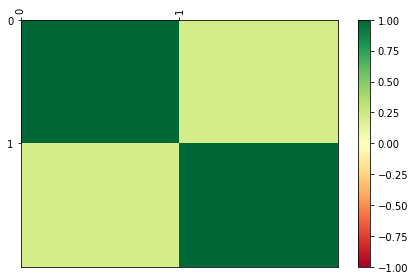

In [47]:
visualize_data(data_selection)

Keeping in mind that this data is from 2012, we can see that there isn't a very strong correlation (0.21) this data between
prescription painkiller abuse and heroin use. OxyCotin was released in 1995 ([Timeline](https://www.fda.gov/media/106638/download)
, [Opioid Overdose Crisis](https://www.drugabuse.gov/drugs-abuse/opioids/opioid-overdose-crisis)) so this data is only at
the beginning of the modern day crisis, before the current epidemic.

## Beginning Age of Use as an Indicator of Later Drug Use
One possible indication of later hard drug use is if the person started using cigarettes or drugs at a young age.
Potentally, the younger the age, the more likely they would be to move on to harder drugs to get their fix as lesser
drugs have a weakened effect.

Variables from the NSDUH study:
* IRCIGAGE: IMPUTATION-REVISED CIGARETTE AGE OF FIRST USE

    991 = NEVER USED
    
    All others are ages

* IRMJAGE: IMPUTATION-REVISED MARIJUANA AGE OF FIRST USE

    991 = NEVER USED
    
    All others are ages
    
* IRCOCAGE: IMPUTATION-REVISED COCAINE AGE OF FIRST USE

    991 = NEVER USED
    
    All others are ages
    
* COCEVER: EVER USED COCAINE

    1 = yes
    
    0 = no
    
* HEREVER: EVER USED HEROIN

    1 = yes
    
    0 = no

* --HALLUCINOGENS
* LSD: EVER USED LSD ("ACID")

    1 = yes
    
    0 = no

* --INHALANTS
* AMYLNIT: EVER INHALED AMYL NITRITE, 'POPPERS,' RUSH, ETC. Freq Pct

    1 = yes
    
    0 = no

* --PAIN RELIEVERS
* DARVTYLC: EVER USED DARVOCET, DARVON, OR TYLENOL W/ CODEINE

    1 = yes
    
    0 = no

We can see from the data that there seem to be some extremely young ages, such as 1, 2, 3, etc at which people
began smoking. It is seemingly impossible for a baby to smoke, but it is possible that they were potentially around
smoking so much that they could be considered a smoker via second hand smoke. None the less, these are likely outliers
in the data, we also should keep in mind that this data is self reported.


In [6]:
data_selection = data[["IRCIGAGE", "IRMJAGE", "IRCOCAGE", "COCEVER", "HEREVER", "LSD", "AMYLNIT", "DARVTYLC"]]

ages = data_selection[["IRCIGAGE", "IRMJAGE", "IRCOCAGE"]]
print(ages.describe())
print()
print(ages.apply(pd.Series.value_counts).sort_index())


           IRCIGAGE       IRMJAGE      IRCOCAGE
count  55268.000000  55268.000000  55268.000000
mean     498.886336    598.704078    885.414869
std      487.746581    477.915086    302.311272
min        1.000000      2.000000      1.000000
25%       15.000000     17.000000    991.000000
50%       28.000000    991.000000    991.000000
75%      991.000000    991.000000    991.000000
max      991.000000    991.000000    991.000000

     IRCIGAGE  IRMJAGE  IRCOCAGE
1         7.0      NaN       3.0
2         4.0      1.0       3.0
3        16.0      1.0       1.0
4        22.0      5.0       3.0
5        82.0     13.0       1.0
6       122.0     14.0       NaN
7       201.0     43.0       2.0
8       333.0     86.0       1.0
9       421.0    117.0       5.0
10      794.0    218.0       2.0
11      737.0    332.0      15.0
12     2416.0   1140.0      38.0
13     2617.0   1906.0      67.0
14     2908.0   2383.0     162.0
15     3734.0   3058.0     343.0
16     3779.0   3597.0     592.0
17    

In [7]:
import numpy as np
# COCAINE
data_selection.loc[data_selection['COCEVER'] != 1, 'COCEVER'] = 0

# HEROIN
data_selection.loc[data_selection['HEREVER'] != 1, 'HEREVER'] = 0

# HALLUCINOGENS
data_selection.loc[data_selection['LSD'] != 91, 'LSD'] = 1
data_selection.loc[data_selection['LSD'] == 91, 'LSD'] = 0

# INHALANTS
data_selection.loc[data_selection['AMYLNIT'] != 91, 'AMYLNIT'] = 1
data_selection.loc[data_selection['AMYLNIT'] == 91, 'AMYLNIT'] = 0

# PAIN RELIEVERS
data_selection.loc[(data_selection["DARVTYLC"] == 91) | (data_selection["DARVTYLC"] == 81), 'DARVTYLC'] = 0
data_selection.loc[(data_selection["DARVTYLC"] != 0), 'DARVTYLC'] = 1

Since we have a mixture of continuous and binary variables,
pandas will use a different correlation method than the standard Pearson correlation coefficient. The method used is the 
Point-Biserial correlation coefficient is a correlation measure of the strength of association between a continuous-level 
variable (ratio or interval data) and a binary variable, you can learn more about this method 
[here](https://www.statisticssolutions.com/point-biserial-correlation/).


We can see below that there are relatively small correlation coefficients between starting age of most drugs, with the
exception of the cocaine age and cocaine drug use. We can see that there seems to be an extremely strong negative correlation 
between cocaine age and cocaine usage, suggesting that as as age goes up, there is a large decrease in trying cocaine.


If we look into this a bit more, we can discover that only a small proportion of people in the study ever used cocaine,
and that those people are marked with a "991" for their age. This could potentially explain the extremely larger negative
correlation coefficient. If we rerun the data with just cocaine users and their age, we can see that the correlation
really drops out, and shows that we need to be careful with correlation and how our data is constructed and labeled. 
*This observation is present in the rest of the age data as well, making us evaluate each set of ages and effects 
individually*.

          IRCIGAGE   IRMJAGE  IRCOCAGE   COCEVER   HEREVER       LSD  \
IRCIGAGE  1.000000  0.558225  0.314093 -0.313990 -0.115973 -0.324698   
IRMJAGE   0.558225  1.000000  0.411730 -0.411628 -0.145131 -0.439352   
IRCOCAGE  0.314093  0.411730  1.000000 -0.999799 -0.319101 -0.575546   
COCEVER  -0.313990 -0.411628 -0.999799  1.000000  0.318479  0.574959   
HEREVER  -0.115973 -0.145131 -0.319101  0.318479  1.000000  0.255902   
LSD      -0.324698 -0.439352 -0.575546  0.574959  0.255902  1.000000   
AMYLNIT  -0.177535 -0.232464 -0.323205  0.322684  0.195508  0.351173   
DARVTYLC -0.256342 -0.331628 -0.370311  0.369791  0.213250  0.397328   

           AMYLNIT  DARVTYLC  
IRCIGAGE -0.177535 -0.256342  
IRMJAGE  -0.232464 -0.331628  
IRCOCAGE -0.323205 -0.370311  
COCEVER   0.322684  0.369791  
HEREVER   0.195508  0.213250  
LSD       0.351173  0.397328  
AMYLNIT   1.000000  0.290249  
DARVTYLC  0.290249  1.000000  


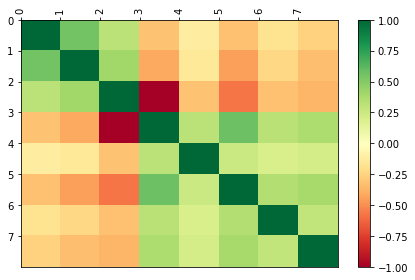

In [52]:
visualize_data(data_selection)

Now, we will analyze beginning cigarette usage and hard drug use.

In [27]:
def age_graph_dist(data, drug_age_str):
    desc = data.describe()
    x = np.linspace(desc[drug_age_str]["min"], desc[drug_age_str]["max"], num=50)
    
    median = data[drug_age_str].median()
    mu = desc[drug_age_str]["mean"]
    sigma = desc[drug_age_str]["std"]
    kertosis = data.kurtosis()[drug_age_str]
    y = stats.norm.pdf(x, mu, sigma)
    
    fig = plt.figure(figsize=(8, 5))
    grid = (10, 1)
    
    ax1 = plt.subplot2grid(grid, (0,0), rowspan=4, colspan=1)
    ax1.plot(x, y, 'r--')
    ax1.text(35, 0.075, 'mean: {}'.format(round(mu, 4)))
    ax1.text(35, 0.060, 'std: {}'.format(round(sigma, 4)))
    ax1.text(35, 0.045, 'kertosis: {}'.format(round(kertosis, 4)))
    
    ax2 = plt.subplot2grid(grid, (4,0), rowspan=4, colspan=1, sharex=ax1)
    ax2.hist(data[drug_age_str].values, 10)
    
    ax3 = plt.subplot2grid(grid, (8,0), rowspan=2, colspan=1, sharex=ax1)
    data.boxplot(drug_age_str, ax=ax3, vert=False)
    ax3.text(0, 0.6, 'median: {}'.format(round(median, 4)))
    plt.tight_layout()
    fig.subplots_adjust(hspace=4.5)
    plt.show()

#### Cigarette
We can see below that the mean age of first cigarette use in about 15.5 years old, well below the age of 18 to buy cigarettes,
but we can also see the kertosis is 8.44, which indicates that this is not a normal distribution and that a five number
summary would be a better indicate the spread. We can see on the box plot that the median age is 15 
as well, indicating that the average age of first cigarette use is rather low. 
The age of first trying cigarettes is weakly negatively correlated with eventual hard drug use.
This data shows that the older you are, the less likely you are to try any hard drug, but not substantially less likely
with each additional year of age. The only notable value is the negative correlation with ever abusing prescription
pain killers. This could be due to somewhat similar but milder effects in using cigarettes which are plentiful,
so no need to try and branch into pain killers.

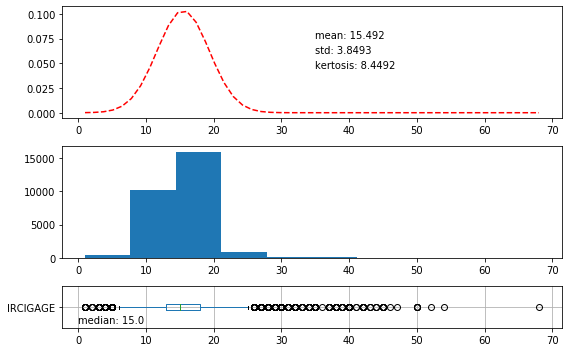

          IRCIGAGE   COCEVER   HEREVER       LSD   AMYLNIT  DARVTYLC
IRCIGAGE  1.000000 -0.133184 -0.097614 -0.144238 -0.157687 -0.140910
COCEVER  -0.133184  1.000000  0.304264  0.547300  0.321687  0.356510
HEREVER  -0.097614  0.304264  1.000000  0.242831  0.202882  0.215645
LSD      -0.144238  0.547300  0.242831  1.000000  0.346085  0.386325
AMYLNIT  -0.157687  0.321687  0.202882  0.346085  1.000000  0.287808
DARVTYLC -0.140910  0.356510  0.215645  0.386325  0.287808  1.000000


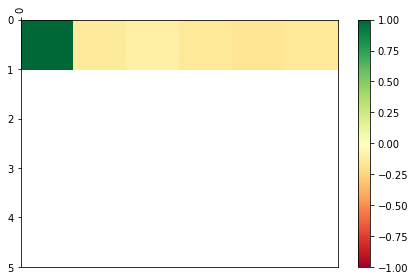

In [28]:
from scipy import stats
# remove people who have never tried anything
rows_to_delete = data_selection[(data_selection["IRCIGAGE"] == 991) & 
                                (data_selection["IRMJAGE" ] == 991) &
                                (data_selection["IRCOCAGE"] == 991) ].index
data_selection.drop(rows_to_delete , inplace=True)

cig_age_data = data_selection[data_selection['IRCIGAGE'] != 991]
cig_age_data.drop(["IRMJAGE", "IRCOCAGE"] , inplace=True, axis=1)

age_graph_dist(cig_age_data, "IRCIGAGE")
visualize_data(cig_age_data, [0])

#### Marijuana
We can see that the mean age of first marijuana use is 16.5 and the kertosis is 17.6, indicating that this also is not a normal
the distribution is not normal. We can see from the 5 box plot that the median slightly lower than the mean at 16 years old, and
that there is a large portion of people in the younger age brackets, while the mean indicates an upward skew, and looking at
the box plot, we can see that there are a lot of outliers at the higher ages.
Looking at the starting age of marijuana use, we can see that again, the relationships are weakly negative with age across
the board. LSD is the most negative at -0.21, showing that as age goes up, the tendency to try LSD goes down. While this is
a weak finding, it is plausible that the older someone is at the start of trying marijuana, the less likely they are to
need a stronger drug as they don't have as much time to build up a tolerance.

(9129, 8)
(22249, 8)
           IRMJAGE   COCEVER   HEREVER       LSD   AMYLNIT  DARVTYLC
IRMJAGE   1.000000 -0.166748 -0.122773 -0.213517 -0.164184 -0.190010
COCEVER  -0.166748  1.000000  0.291925  0.503942  0.297608  0.322436
HEREVER  -0.122773  0.291925  1.000000  0.224179  0.192636  0.208785
LSD      -0.213517  0.503942  0.224179  1.000000  0.320252  0.346951
AMYLNIT  -0.164184  0.297608  0.192636  0.320252  1.000000  0.268607
DARVTYLC -0.190010  0.322436  0.208785  0.346951  0.268607  1.000000


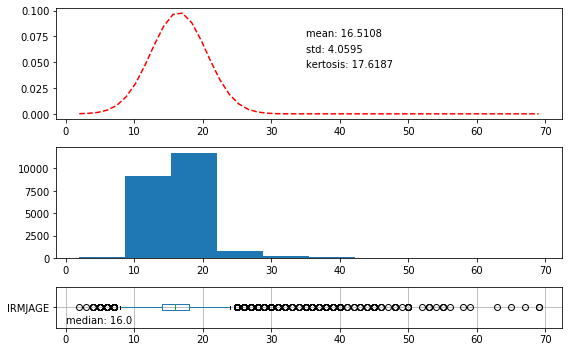

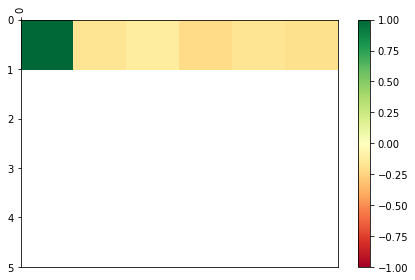

In [29]:
print(data_selection[data_selection['IRMJAGE'] == 991].shape)
print(data_selection[data_selection['IRMJAGE'] != 991].shape)
coc_age_data = data_selection[data_selection['IRMJAGE'] != 991]
coc_age_data.drop(["IRCOCAGE", "IRCIGAGE"] , inplace=True, axis=1)

age_graph_dist(coc_age_data, "IRMJAGE")
visualize_data(coc_age_data, [0])

#### Cocaine
We can see that the mean for the age of first cocaine use is 19.88, the oldest age so far. Our kertosis is 6.2, which again,
shows this is not a normal distribution, but our median is slightly lower than our mean, at 19 years old.
Finally we look at the relationship between starting age of cocaine use and hard drug use, we can see that, unsurprisingly,
there is a positive relationship between the age of trying cocaine and having ever tried cocaine. Across the rest of the
board, the results are similar to the starting age of cigarette use, with a notably lower correlation coefficient in
prescription pain killer abuse.

(25369, 8)
(6009, 8)
          IRCOCAGE   COCEVER   HEREVER       LSD   AMYLNIT  DARVTYLC
IRCOCAGE  1.000000  0.001432 -0.145659 -0.165516 -0.135938 -0.201559
COCEVER   0.001432  1.000000  0.006912 -0.012023 -0.006028  0.001803
HEREVER  -0.145659  0.006912  1.000000  0.145700  0.166410  0.202859
LSD      -0.165516 -0.012023  0.145700  1.000000  0.271761  0.254029
AMYLNIT  -0.135938 -0.006028  0.166410  0.271761  1.000000  0.236419
DARVTYLC -0.201559  0.001803  0.202859  0.254029  0.236419  1.000000


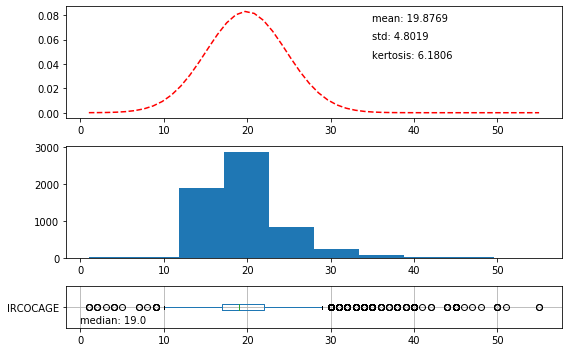

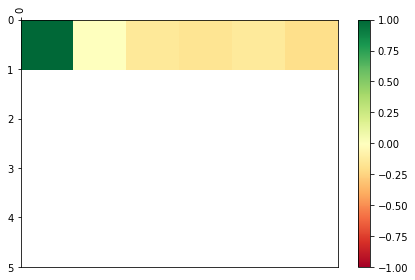

In [30]:
print(data_selection[data_selection['IRCOCAGE'] == 991].shape)
print(data_selection[data_selection['IRCOCAGE'] != 991].shape)
coc_age_data = data_selection[data_selection['IRCOCAGE'] != 991]
coc_age_data.drop(["IRMJAGE", "IRCIGAGE"] , inplace=True, axis=1)

age_graph_dist(coc_age_data, "IRCOCAGE")
visualize_data(coc_age_data, [0])

## Conclusion
In conclusion, we found that there is evidence in our data of the addictive quality of cigarettes, as the correlation 
coefficient between trying cigarettes and being a chronic user is moderately high. We also found there is also no significant overlap 
between cigarette users and marijuana users however, there is an indication that trying cigarettes will lead to trying marijuana.

We also saw that there is evidence in our data that the majority of chronic marijuana
users do not go on to use harder drugs, with exceptions being LSD and cocaine. We also explored some possible explanations
for this correlation.

Surprisingly, we also found that the data showed there is only a weak correlation (0.21) between prescription painkiller abuse and 
heroin use. This is likely due to the year this data was collected as it took many years for the epidemic to set in.

Finally, we found that age of starting a drug has a seemingly small correlation with later trying harder drugs, with most of
the correlations between starting cigarette use age, starting marijuana use age and starting cocaine use age being right
around each other.
